In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import sys
import re
sys.path.append('../')

from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import TFAutoModel
from tensorflow_tts.inference import AutoProcessor
from tensorflow_tts.models import TFParallelWaveGANGenerator,TFMelGANGenerator, TFPQMF
from tensorflow_tts.configs import ParallelWaveGANGeneratorConfig, MultiBandMelGANGeneratorConfig
import torch
from parallel_wavegan.models import ParallelWaveGANGenerator
import IPython.display as ipd

In [2]:
import glob
import tempfile
import time

import librosa.display
import yaml

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import GridBox, Label, Layout, Audio
from tensorflow_tts.utils import TFGriffinLim, griffin_lim_lb


In [3]:
def replace_words(text,dictionary):
    for key in dictionary.keys():
        text = text.replace(key, dictionary[key])
    return text

conversion_dict = {
    '%' : ' porcento',
    'PSOL': 'pêssól',
    'OAB': 'Oabê',
    'SP': 'São Paulo',
    'RJ': 'Rio de Janeiro',
    '°C': ' graus célsius',
    'ºC': ' graus célsius',
    'Globoplay': 'Globoplei',
    'g1': 'gê um',
    'William Bonner': 'uílliam bôner'
    
}
def convert_helper(obj):
    num_in_text = int(obj.group(0))
    return num2words(num_in_text,lang='pt_BR').replace(",","")

def convert_numbers(text):
    return re.sub(r'\d+',convert_helper,text)

In [4]:
acronym_translation = {
    'A': 'a',
    'B': 'bê',
    'C': 'cê',
    'D': 'dê',
    'E': 'é',
    'F': 'éfe',
    'G': 'gê',
    'H': 'agá',
    'I': 'I',
    'J': 'jóta',
    'K': 'cá',
    'L': 'éle',
    'M': 'ême',
    'N': 'êne',
    'O': 'ó',
    'P': 'pê',
    'Q': 'quê',
    'R': 'érre',
    'S': 'ésse',
    'T': 'tê',
    'U': 'u',
    'V': 'vê',
    'W': 'dábliu',
    'X': 'xis',
    'Y': 'ípsilon',
    'Z': 'zê'
}
def convert_helper_acronym(obj):
    acronym = obj.group(0)
    final_text = ''
    for letter in acronym:
        final_text += acronym_translation[letter] + ' '
    return final_text[:-1]

def convert_acronyms(text):
    return re.sub(r"\b[A-Z]{2,}\b",convert_helper_acronym,text)
def normalize_text(input_text,dictionary):
    output_text = replace_words(input_text,dictionary)
    output_text = convert_numbers(output_text)
    
    output_text = convert_acronyms(output_text)
    return output_text

In [5]:
stats_path = "/mnt/c/Users/pedro/Documents/TTS/TensorFlowTTS/dump_ljspeech/stats.npy"
dataset_config_path = "/mnt/c/Users/pedro/Documents/TTS/TensorFlowTTS/preprocess/ljspeech_preprocess.yaml"
# stats_path = "/mnt/c/Users/pedro/Documents/TTS/TensorFlowTTS/stats_44.npy"
# dataset_config_path = "/mnt/c/Users/pedro/Documents/TTS/TensorFlowTTS/preprocess/ljspeechu_preprocess.yaml"
config = yaml.load(open(dataset_config_path), Loader=yaml.Loader)



In [6]:
processor = AutoProcessor.from_pretrained("/mnt/c/Users/pedro/Documents/TTS/TensorFlowTTS/dump_ljspeech/ljspeech_mapper.json")

In [7]:
cfg = AutoConfig.from_pretrained('/mnt/c/Users/pedro/Documents/TTS/TensorFlowTTS/examples/tacotron2/exp/train.tacotron2.v1/config.yml')
#cfg = AutoConfig.from_pretrained('/mnt/c/Users/pedro/Documents/TTS/TensorFlowTTS/tacotron2.lju.v1.yaml')
#tacotron2 = TFAutoModel.from_pretrained("/mnt/c/Users/pedro/Documents/TTS/TensorFlowTTS/examples/tacotron2/exp/train.tacotron2.v1/checkpoints/model-122000.h5",cfg)
tacotron2 = TFAutoModel.from_pretrained("/mnt/c/Users/pedro/Documents/TTS/serve-tts/models/tacotron-base.h5",cfg)

tacotron2.setup_window(win_front=6, win_back=6)
tacotron2.setup_maximum_iterations(3000)

2022-08-22 08:47:01.228729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-22 08:47:01.281161: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-22 08:47:01.281390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-22 08:47:01.282220: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the app

In [8]:
cfg1 = AutoConfig.from_pretrained('/mnt/c/Users/pedro/Documents/TTS/serve-tts/models/cfg_tf_22.yaml')
vocoder_conf = '/mnt/c/Users/pedro/Documents/TTS/serve-tts/models/cfg_pytorch_22.yaml'

# cfg1 = AutoConfig.from_pretrained('/mnt/c/Users/pedro/Documents/TTS/ParallelWaveGAN/parallel_wavegan_44.yaml')
# vocoder_conf = '/mnt/c/Users/pedro/Documents/TTS/ParallelWaveGAN/parallel_wavegan_44_2.yaml'
with open(vocoder_conf) as f:
    cfg = yaml.load(f, Loader=yaml.Loader)
cfg

{'sampling_rate': 22050,
 'fft_size': 1024,
 'hop_size': 256,
 'win_length': None,
 'window': 'hann',
 'num_mels': 80,
 'fmin': 80,
 'fmax': 7600,
 'global_gain_scale': 1.0,
 'trim_silence': True,
 'trim_threshold_in_db': 60,
 'trim_frame_size': 2048,
 'trim_hop_size': 512,
 'format': 'hdf5',
 'generator_params': {'in_channels': 1,
  'out_channels': 1,
  'kernel_size': 3,
  'layers': 30,
  'stacks': 3,
  'residual_channels': 64,
  'gate_channels': 128,
  'skip_channels': 64,
  'aux_channels': 80,
  'aux_context_window': 2,
  'dropout': 0.0,
  'use_weight_norm': True,
  'upsample_net': 'ConvInUpsampleNetwork',
  'upsample_params': {'upsample_scales': [4, 4, 4, 4]}},
 'discriminator_params': {'in_channels': 1,
  'out_channels': 1,
  'kernel_size': 3,
  'layers': 10,
  'conv_channels': 64,
  'bias': True,
  'use_weight_norm': True,
  'nonlinear_activation': 'LeakyReLU',
  'nonlinear_activation_params': {'negative_slope': 0.2}},
 'stft_loss_params': {'fft_sizes': [1024, 2048, 512],
  'hop_

In [9]:

#tf_model = TFParallelWaveGANGenerator(config=ParallelWaveGANGeneratorConfig(), name="parallel_wavegan_generator")
tf_model = TFParallelWaveGANGenerator(config=cfg1, name="parallel_wavegan_generator")
tf_model._build()

In [10]:

torch_checkpoints = torch.load("/mnt/c/Users/pedro/Documents/TTS/serve-tts/models/p-wavegan-base.pkl", map_location=torch.device('cpu'))
#torch_checkpoints = torch.load("/mnt/c/Users/pedro/Documents/TTS/ParallelWaveGAN/checkpoint-477500steps.pkl", map_location=torch.device('cpu'))
torch_generator_weights = torch_checkpoints["model"]["generator"]
torch_model = ParallelWaveGANGenerator(**cfg["generator_params"])
torch_model.load_state_dict(torch_checkpoints["model"]["generator"])
torch_model.remove_weight_norm()

In [11]:
def convert_weights_pytorch_to_tensorflow(weights_pytorch):
    """
    Convert pytorch Conv1d weight variable to tensorflow Conv2D weights.
    1D: Pytorch (f_output, f_input, kernel_size) -> TF (kernel_size, f_input, 1, f_output)
    2D: Pytorch (f_output, f_input, kernel_size_h, kernel_size_w) -> TF (kernel_size_w, kernel_size_h, f_input, 1, f_output)
    """
    if len(weights_pytorch.shape) == 3: # conv1d-kernel
        weights_tensorflow = np.transpose(weights_pytorch, (0,2,1))  # [f_output, kernel_size, f_input]
        weights_tensorflow = np.transpose(weights_tensorflow, (1,0,2))  # [kernel-size, f_output, f_input]
        weights_tensorflow = np.transpose(weights_tensorflow, (0,2,1))  # [kernel-size, f_input, f_output]
        return weights_tensorflow
    elif len(weights_pytorch.shape) == 1: # conv1d-bias
        return weights_pytorch
    elif len(weights_pytorch.shape) == 4: # conv2d-kernel
        weights_tensorflow = np.transpose(weights_pytorch, (0,2,1,3))  # [f_output, kernel_size_h, f_input, kernel_size_w]
        weights_tensorflow = np.transpose(weights_tensorflow, (1,0,2,3))  # [kernel-size_h, f_output, f_input, kernel-size-w]
        weights_tensorflow = np.transpose(weights_tensorflow, (0,2,1,3))  # [kernel_size_h, f_input, f_output, kernel-size-w]
        weights_tensorflow = np.transpose(weights_tensorflow, (0,1,3,2))  # [kernel_size_h, f_input, kernel-size-w, f_output]
        weights_tensorflow = np.transpose(weights_tensorflow, (0,2,1,3))  # [kernel_size_h, kernel-size-w, f_input, f_output]
        weights_tensorflow = np.transpose(weights_tensorflow, (1,0,2,3))  # [kernel-size_w, kernel_size_h, f_input, f_output]
        return weights_tensorflow

torch_weights = []
all_keys = list(torch_model.state_dict().keys())
all_values = list(torch_model.state_dict().values())

idx_already_append = []

for i in range(len(all_keys) -1):
    if i not in idx_already_append:
        if all_keys[i].split(".")[0:-1] == all_keys[i + 1].split(".")[0:-1]:
            if all_keys[i].split(".")[-1] == "bias" and all_keys[i + 1].split(".")[-1] == "weight":
                torch_weights.append(convert_weights_pytorch_to_tensorflow(all_values[i + 1].cpu().detach().numpy()))
                torch_weights.append(convert_weights_pytorch_to_tensorflow(all_values[i].cpu().detach().numpy()))
                idx_already_append.append(i)
                idx_already_append.append(i + 1)
        else:
            if i not in idx_already_append:
                torch_weights.append(convert_weights_pytorch_to_tensorflow(all_values[i].cpu().detach().numpy()))
                idx_already_append.append(i)

In [12]:
from num2words import num2words
input_text = "O Banco Central do Brasil tem seis dicas para ajudar a identificar se uma nota é verdadeira ou falsa. As dicas passam por elementos gráficos e físicos da célula, como uma marca d’água e um relevo em partes específicas."
input_text = normalize_text(input_text,conversion_dict)
print(input_text)
input_ids = processor.text_to_sequence(input_text)

O Banco Central do Brasil tem seis dicas para ajudar a identificar se uma nota é verdadeira ou falsa. As dicas passam por elementos gráficos e físicos da célula, como uma marca d’água e um relevo em partes específicas.


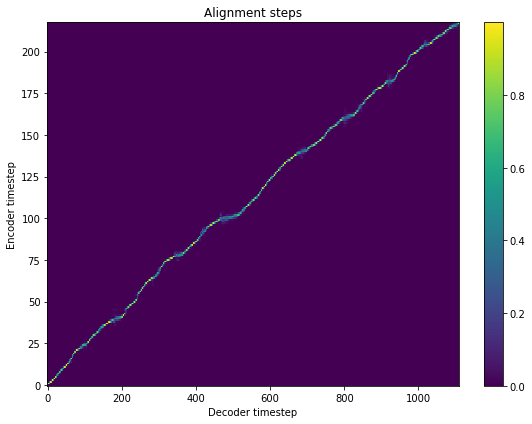

In [13]:
decoder_output, mel_outputs, stop_token_prediction, alignment_history = tacotron2.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        tf.convert_to_tensor([len(input_ids)], tf.int32),
        tf.convert_to_tensor([0], dtype=tf.int32)
)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title(f'Alignment steps')
im = ax.imshow(
    alignment_history[0].numpy(),
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()
plt.close()

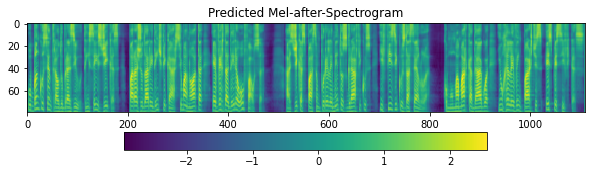

In [14]:
mel_outputs = tf.reshape(mel_outputs, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()

In [15]:
tf_var = tf_model.trainable_variables
for i, var in enumerate(tf_var):
    tf.keras.backend.set_value(var, torch_weights[i])
audio = tf_model(tf.expand_dims(mel_outputs,axis=0))[0, :, 0]
ipd.Audio(audio.numpy(),rate=config['sampling_rate'])

In [35]:
import noisereduce as nr
reduced_noise = nr.reduce_noise(y=audio.numpy(), sr=config['sampling_rate'],prop_decrease=0.9)
ipd.Audio(reduced_noise,rate=config['sampling_rate'])

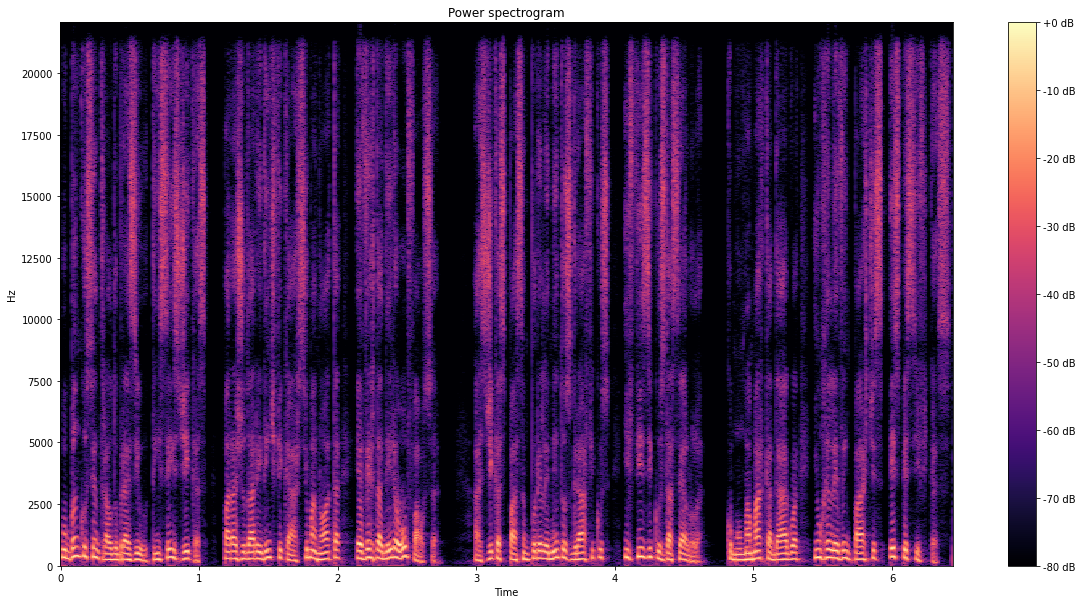

In [16]:
D = librosa.stft(audio.numpy())  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.rcParams['figure.figsize'] = (20,10)
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db,
                            y_axis='hz',x_axis='time', ax=ax,sr=44100)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()

In [17]:
D = librosa.stft(reduced_noise)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.rcParams['figure.figsize'] = (20,10)
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db,
                            y_axis='hz',x_axis='time', ax=ax,sr=44100)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()

NameError: name 'reduced_noise' is not defined

In [21]:
config_mb_melgan_path = '/mnt/c/Users/pedro/Documents/TTS/TensorFlowTTS/examples/multiband_melgan_hf/conf/multiband_melgan_hf.lju.v1ft.yml'
with open(config_mb_melgan_path) as f:
        config = yaml.load(f, Loader=yaml.Loader)
mb_melgan = TFMelGANGenerator(
        config=MultiBandMelGANGeneratorConfig(**config["multiband_melgan_generator_params"]),
        name="multiband_melgan_generator",
    )
mb_melgan._build()
mb_melgan.load_weights('/mnt/c/Users/pedro/Documents/TTS/TensorFlowTTS/generator-588000.h5')
pqmf = TFPQMF(
        config=MultiBandMelGANGeneratorConfig(**config["multiband_melgan_generator_params"]), name="pqmf"
    )

In [22]:

generated_subbands = mb_melgan(mel_outputs[None,...])
generated_audios = pqmf.synthesis(generated_subbands)

# convert to numpy.
generated_audios = generated_audios.numpy()  # [B, T]
generated_audios.shape

(1, 567808, 1)

In [25]:
567808/597504

0.9502999143101971

In [23]:
ipd.Audio(generated_audios[0,:,0],rate=44100)

In [24]:
import noisereduce as nr
reduced_noise = nr.reduce_noise(y=generated_audios[0,:,0], sr=44100,prop_decrease=0.3)
ipd.Audio(reduced_noise,rate=44100)

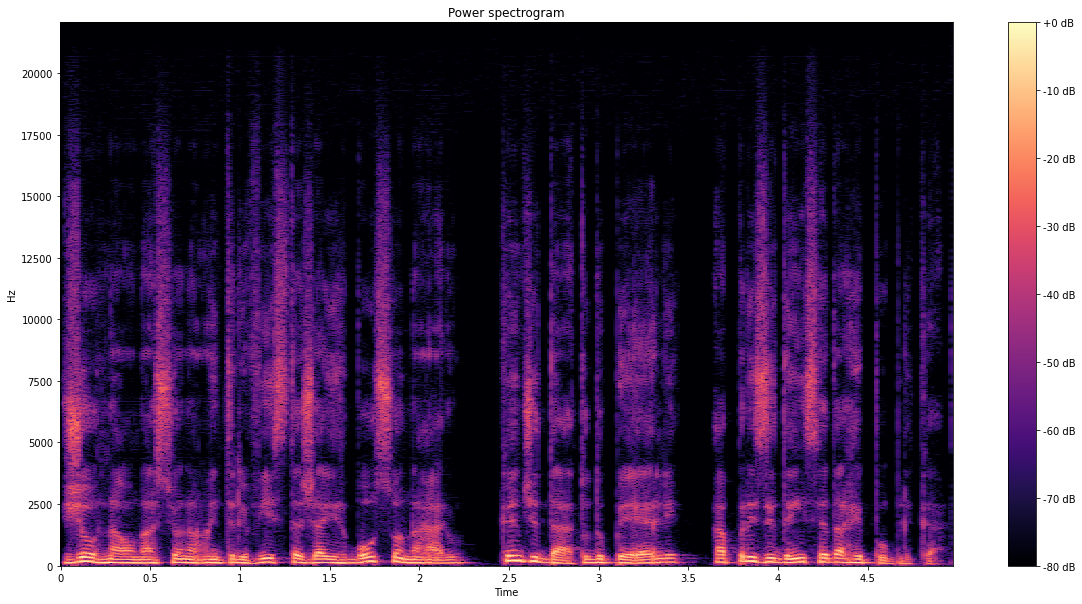

In [54]:
D = librosa.stft(generated_audios[0,:,0])  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.rcParams['figure.figsize'] = (20,10)
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db,
                            y_axis='hz',x_axis='time', ax=ax,sr=44100)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()

In [43]:
# stats = np.load('/mnt/c/Users/pedro/Documents/TTS/stats_44.npy')
stats = np.load('/mnt/c/Users/pedro/Documents/TTS/TensorFlowTTS/dump_ljspeech/stats.npy')
stats.shape

(2, 80)

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.mean_, scaler.scale_ = stats
scaler.n_features_in_ = 80
D = librosa.stft(
        audio.numpy(),
        n_fft=1024,
        hop_length=256,
        win_length=1024,
        window='hann',
        pad_mode="reflect",
    )
S, _ = librosa.magphase(D)  # (#bins, #frames)

# get mel basis
fmin = 0 
fmax = 11050
mel_basis = librosa.filters.mel(
    sr=22050,
    n_fft=1024,
    n_mels=80,
    fmin=fmin,
    fmax=fmax,
)
mel = np.log10(np.maximum(np.dot(mel_basis, S), 1e-10)).T  # (#frames, #bins)

S_final =scaler.transform(mel)

In [45]:
plt.pcolormesh(S_dB)

NameError: name 'S_dB' is not defined

In [ ]:
config_mb_melgan_path = '/mnt/c/Users/pedro/Documents/TTS/TensorFlowTTS/examples/multiband_melgan_hf/conf/multiband_melgan_hf.lju.v1ft.yml'
with open(config_mb_melgan_path) as f:
        config = yaml.load(f, Loader=yaml.Loader)
mb_melgan = TFMelGANGenerator(
        config=MultiBandMelGANGeneratorConfig(**config["multiband_melgan_generator_params"]),
        name="multiband_melgan_generator",
    )
mb_melgan._build()
mb_melgan.load_weights('/mnt/c/Users/pedro/Documents/TTS/TensorFlowTTS/generator-161000.h5')
pqmf = TFPQMF(
        config=MultiBandMelGANGeneratorConfig(**config["multiband_melgan_generator_params"]), name="pqmf"
    )

In [46]:

generated_subbands = mb_melgan(S_final[None,...])
generated_audios = pqmf.synthesis(generated_subbands)

# convert to numpy.
generated_audios = generated_audios.numpy()  # [B, T]
generated_audios.shape

(1, 219648, 1)

In [47]:
ipd.Audio(generated_audios[0,:,0],rate=44100)

In [48]:
cfg1 = AutoConfig.from_pretrained('/mnt/c/Users/pedro/Documents/TTS/ParallelWaveGAN/parallel_wavegan_44.yaml')
vocoder_conf = '/mnt/c/Users/pedro/Documents/TTS/ParallelWaveGAN/parallel_wavegan_44_2.yaml'
with open(vocoder_conf) as f:
    cfg = yaml.load(f, Loader=yaml.Loader)
tf_model = TFParallelWaveGANGenerator(config=cfg1, name="parallel_wavegan_generator")
tf_model._build()
torch_checkpoints = torch.load("/mnt/c/Users/pedro/Documents/TTS/serve-tts/models/p-wavegan-base.pkl", map_location=torch.device('cpu'))
#torch_checkpoints = torch.load("/mnt/c/Users/pedro/Documents/TTS/ParallelWaveGAN/checkpoint-477500steps.pkl", map_location=torch.device('cpu'))
torch_generator_weights = torch_checkpoints["model"]["generator"]
torch_model = ParallelWaveGANGenerator(**cfg["generator_params"])
torch_model.load_state_dict(torch_checkpoints["model"]["generator"])
torch_model.remove_weight_norm()

RuntimeError: Error(s) in loading state_dict for ParallelWaveGANGenerator:
	size mismatch for upsample_net.upsample.up_layers.7.weight_v: copying a param with shape torch.Size([1, 1, 1, 9]) from checkpoint, the shape in current model is torch.Size([1, 1, 1, 17]).